<a href="https://colab.research.google.com/github/kumar-abhishek/imbalanced-machine-learning-book/blob/main/chapter-10/model_calibration_on_Kaggle_HR_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### [Brief about Data](https://www.kaggle.com/datasets/jacksonchou/hr-data-for-analytics#Breif-about-Data-:)

Data is about Human resources in a specific company each record represents an employee

#### [Variables description](https://www.kaggle.com/code/ahmedhas93/hr-data-cleaning-outliers-analysis-eda-lr-rf/notebook#Variables-description-:)

Dependent variable

-   Left : 0 if employee did not leave , 1 if left company

Independent variables

-   satisfaction_level : means how much employee satisfied (0 less satisfied , 1 most satisfied)
-   last_evaluation : means employees' evaluation for last month (0 bad , 1 Excellent)
-   number_project : number of projects the employee worked on
-   average_montly_hours : average months employee spends at work per month
-   time_spend_company : years the employee spent in a company
-   Work_accident : 0 if he did not have an accident , 1 if had at least one
-   promotion_last_5years : 0 if he did not have any promotion in last 5 years , 1 if had at least one
-   sales : department in which employee works


# Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import brier_score_loss


# EDA

In [5]:
# Load the dataset
df = pd.read_csv('HR_comma_sep.csv')

In [6]:
df

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


# Check Data imbalance

0    11428
1     3571
Name: left, dtype: int64


<Axes: >

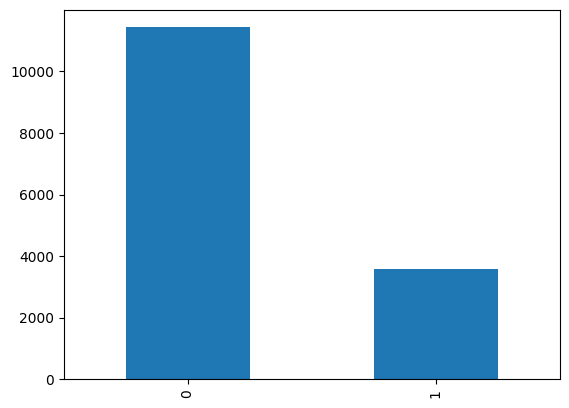

In [7]:
import seaborn as sns

print(df['left'].value_counts())
df['left'].value_counts().plot(kind='bar')


# Convert categorical columns to label encoded

In [8]:
le = LabelEncoder()
for column in df.columns:
    if df[column].dtype == object:
        df[column] = le.fit_transform(df[column])



# Split the data into training, testing, and validation sets



In [9]:
X = df.drop('left', axis=1)
y = df['left']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.33, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Train a random forest model


In [10]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# Plot calibration curve for raw model

In [27]:
# Get the model probabilities on the test set (uncalibrated model)
probs_uncalibrated = model.predict_proba(X_test)[:, 1]

# Calculate Brier score for the uncalibrated model
brier_uncalibrated = brier_score_loss(y_test, probs_uncalibrated)
print(f"Brier Score for Uncalibrated Model: {round(brier_uncalibrated, 4)}")

# Compute the calibration curve for the uncalibrated model
fraction_of_positives_uncalibrated, mean_predicted_value_uncalibrated = calibration_curve(y_test, probs_uncalibrated, n_bins=10)


Brier Score for Uncalibrated Model: 0.0123


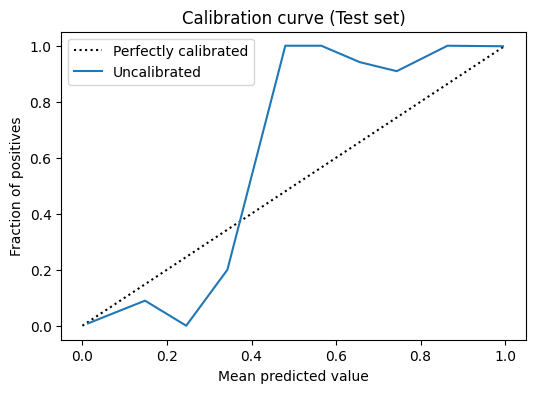

In [17]:
plt.figure(figsize=(6, 4))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.plot(mean_predicted_value_uncalibrated, fraction_of_positives_uncalibrated, label="Uncalibrated")
plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve (Test set)')
plt.legend()
plt.show()


# Calibration using Platt's scaling

In [28]:
# Calibrate the model on the validation data using Platt's scaling
platt_scaling = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
platt_scaling.fit(X_val, y_val)

# Get the model probabilities on the test set (calibrated model - Platt's scaling)
probs_ps = platt_scaling.predict_proba(X_test)[:, 1]

# Calculate Brier score for the Platt's scaling calibrated model
brier_platt = brier_score_loss(y_test, probs_ps)
print(f"Brier Score for Platt's Scaling Calibrated Model: {round(brier_platt, 4)}")

# Compute the calibration curve for Platt's scaling
fraction_of_positives_ps, mean_predicted_value_ps = calibration_curve(y_test, probs_ps, n_bins=10)


Brier Score for Platt's Scaling Calibrated Model: 0.0106


# Calibration using Platt's scaling

In [29]:
# Calibrate the model on the validation data using isotonic regression
isotonic_regression = CalibratedClassifierCV(model, method='isotonic', cv='prefit')
isotonic_regression.fit(X_val, y_val)

# Get the model probabilities on the test set (calibrated model - Isotonic regression)
probs_ir = isotonic_regression.predict_proba(X_test)[:, 1]

# Calculate Brier score for the isotonic regression calibrated model
brier_isotonic = brier_score_loss(y_test, probs_ir)
print(f"Brier Score for Isotonic Regression Calibrated Model: {round(brier_isotonic, 4)}")

# Compute the calibration curve for isotonic regression
fraction_of_positives_ir, mean_predicted_value_ir = calibration_curve(y_test, probs_ir, n_bins=10)


Brier Score for Isotonic Regression Calibrated Model: 0.0102


# Create a calibration plot


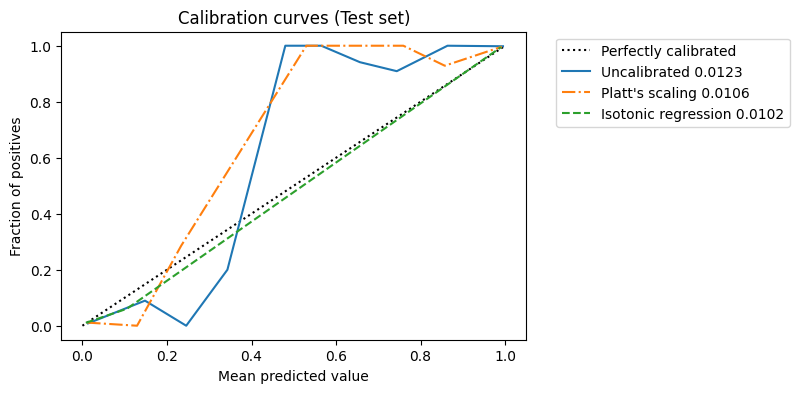

In [26]:
plt.figure(figsize=(6, 4))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.plot(mean_predicted_value_uncalibrated, fraction_of_positives_uncalibrated, label="Uncalibrated %s" % round(brier_uncalibrated, 4))
plt.plot(mean_predicted_value_ps, fraction_of_positives_ps, label="Platt's scaling %s" % round(brier_platt, 4), linestyle='-.')
plt.plot(mean_predicted_value_ir, fraction_of_positives_ir, label="Isotonic regression %s" % round(brier_isotonic, 4), linestyle='--')
plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.title('Calibration curves (Test set)')
# plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()
